### 5.27 Grid Search

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score,
                             accuracy_score)

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

# load data
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# data seems a bit imbalanced
print(type(breast_cancer_X), type(breast_cancer_y))
y.value_counts() / len (y)

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)
X_train.shape, X_test.shape



<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((398, 30), (171, 30))

In [6]:
## Performing Cross-Validation
# build a model
gbm = GradientBoostingClassifier(random_state=0)

# initial grid
param_grid = dict(n_estimators = [10, 25]
                 ,min_samples_split = [0.1, 0.3]
                 ,max_depth = [2,3])

# the grid will search 8 different models (product of each length)

In [7]:
search = GridSearchCV(gbm, param_grid, scoring = 'roc_auc', cv = 5, refit = True)

# find the best hyperparameters
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'max_depth': [2, 3], 'min_samples_split': [0.1, 0.3],
                         'n_estimators': [10, 25]},
             scoring='roc_auc')

In [9]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 0.3, 'n_estimators': 25}

In [10]:
search

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'max_depth': [2, 3], 'min_samples_split': [0.1, 0.3],
                         'n_estimators': [10, 25]},
             scoring='roc_auc')

In [16]:
results = pd.DataFrame(search.cv_results_)

results.shape

(8, 16)

In [18]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012631,0.001769,0.002049,0.000739,2,0.1,10,"{'max_depth': 2, 'min_samples_split': 0.1, 'n_...",0.991667,0.962667,0.972000,0.972759,0.956463,0.971111,0.011933,7
1,0.026420,0.000507,0.001630,0.000508,2,0.1,25,"{'max_depth': 2, 'min_samples_split': 0.1, 'n_...",0.996000,0.975000,0.985333,0.991034,0.980272,0.985528,0.007463,2
2,0.011616,0.000505,0.001378,0.000464,2,0.3,10,"{'max_depth': 2, 'min_samples_split': 0.3, 'n_...",0.991667,0.962667,0.972000,0.972759,0.956463,0.971111,0.011933,7
3,0.027172,0.000362,0.001821,0.000415,2,0.3,25,"{'max_depth': 2, 'min_samples_split': 0.3, 'n_...",0.996667,0.975000,0.985333,0.991034,0.980612,0.985729,0.007606,1
4,0.015362,0.000554,0.001561,0.000692,3,0.1,10,"{'max_depth': 3, 'min_samples_split': 0.1, 'n_...",0.996000,0.968000,0.973667,0.982759,0.970068,0.978099,0.010279,6


In [21]:
results.sort_values(by = 'mean_test_score', ascending = False, inplace = True)
results.reset_index(drop=True, inplace=True)

results.loc[:, ['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score']]

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,2,0.3,25,0.985729,0.007606
1,2,0.1,25,0.985528,0.007463
2,3,0.3,25,0.984782,0.009666
3,3,0.1,25,0.984508,0.009411
4,3,0.3,10,0.978719,0.010629
5,3,0.1,10,0.978099,0.010279
6,2,0.1,10,0.971111,0.011933
7,2,0.3,10,0.971111,0.011933


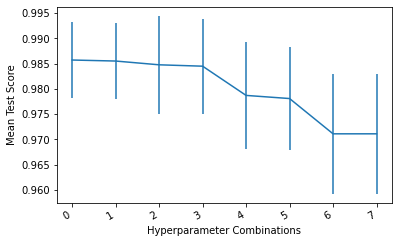

In [25]:
results.mean_test_score.plot(yerr=[results.std_test_score, results.std_test_score], subplots=True)
plt.ylabel('Mean Test Score')
plt.xlabel('Hyperparameter Combinations');

In [27]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train ROC AUC: {train},     Test ROC AUC: {test}'.format(train=roc_auc_score(y_train, X_train_preds)
                                                               ,test=roc_auc_score(y_test, X_test_preds)))

Train ROC AUC: 0.9976280962777284,     Test ROC AUC: 0.9923574368018812


### 4.31 Grid Search with Different Hyperparameter Spaces

Some hyperparameters settings allow only certain hyperparameter spaces of other hyperparameters (for example, certain Support Vector Machine kernels use the 'gamma' HP - others do not

In [32]:
svm = SVC(random_state = 0)

# define a HP grid with multiple settings
param_grid = [
    {'C': [1, 10, 100], 'kernel': ['linear']},
    {'C': [1, 10, 100], 'gamma': [0.001, 0.005], 'kernel': ['rbf']}
]

In [33]:
search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, refit=True)

search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.001, 0.005],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In [34]:
search.best_params_

{'C': 1, 'kernel': 'linear'}

In [36]:
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.507699,0.192642,0.001404,0.000489,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.9875,0.9125,0.9375,0.962025,0.974684,0.954842,0.026853,1
1,2.347901,1.662727,0.001398,0.000487,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.9875,0.9000,0.9375,0.949367,0.962025,0.947278,0.028881,3
2,5.573801,2.614192,0.001625,0.000784,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.9875,0.9125,0.9375,0.962025,0.962025,0.952310,0.025422,2
3,0.007770,0.000727,0.002166,0.000396,1,rbf,0.001,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.9500,0.8875,0.9250,0.898734,0.898734,0.911994,0.022650,6
4,0.010002,0.000686,0.002601,0.000490,1,rbf,0.005,"{'C': 1, 'gamma': 0.005, 'kernel': 'rbf'}",0.7250,0.8625,0.9000,0.911392,0.860759,0.851930,0.066554,9


In [37]:
results.sort_values(by = 'mean_test_score', ascending = False, inplace = True)
results.reset_index(drop=True, inplace=True)

results.loc[:, ['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score
0,1,linear,NaN,0.954842,0.026853
1,100,linear,NaN,0.952310,0.025422
2,10,linear,NaN,0.947278,0.028881
3,10,rbf,0.001,0.917152,0.025564
4,100,rbf,0.001,0.917152,0.025564
5,1,rbf,0.001,0.911994,0.022650
6,10,rbf,0.005,0.896930,0.033253
7,100,rbf,0.005,0.896930,0.033253
8,1,rbf,0.005,0.851930,0.066554


### 4.33 Random Search with Scikit-learn

In [50]:
stats.randint.rvs(10,20)

17

In [51]:
stats.uniform.rvs(0,1)

0.3105657126035112

In [56]:
# model
gbm = GradientBoostingClassifier()

# parameter space to sample
param_grid = dict(n_estimators = stats.randint(10, 200)
                 ,min_samples_split = stats.uniform(0,1)
                 ,max_depth = stats.randint(1,5)
                 ,loss = ('deviance', 'exponential'))

In [57]:
search = RandomizedSearchCV(gbm
                           ,param_grid
                           ,scoring = 'roc_auc'
                           ,cv = 5
                           ,n_iter = 60  # 60 random HP samples
                           ,n_jobs = 4
                           ,refit = True)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=60,
                   n_jobs=4,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018DE812F220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018DE8084D60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018DE81256D0>},
                   scoring='roc_auc')

In [58]:
results = pd.DataFrame(search.cv_results_)

results.sort_values(by = 'mean_test_score', ascending = False, inplace = True)
results.reset_index(drop=True, inplace=True)

results.loc[:, ['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 
                'mean_test_score', 'std_test_score']].head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,3,0.591139,116,0.994651,0.005569
1,4,0.55258,167,0.993710,0.006512
2,3,0.728645,176,0.993448,0.007376
3,2,0.527212,112,0.993294,0.005427
4,4,0.84293,182,0.993184,0.007727


### 4.34 Random Search with scikit-optimize

In [59]:
from skopt import dummy_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

ModuleNotFoundError: No module named 'skopt'

In [ ]:
# setting up the parameter grid
    # have to use the Real, Integer, and Categorical function from scikit-optimize to sample from the HP space
param_grid = [
    Integer(10, 200, name = 'n_estimators'),
    Real(0, 0.999, name = 'min_samples_split'),
    Integer(1, 5, name = 'max_depth'),
    Categorical(['deviance', 'exponential'], name = 'loss')
]

# objective function
    # unlike scikit-learn, we have to specify our own objective function
    # scikit-optimize minimizes so we want the negative accuracy
@use_named_args(param_grid)
def objective(**params):
    # model with new HPs
    gbm.set_params(**params)
    
    # optimization function
    value = np.mean(cross_val_score(gbm
                                   ,X_train
                                   ,y_train
                                   ,cv=5))
    
    return -value

In [ ]:
search = dummy_minimize(objective      # objective function to minimize
                       ,param_grid     # HP space
                       ,n_calls = 50)  # subsequent evaluations of 

### 4.35 Random Search with Hyperopt

In [61]:
import xgboost as xgb
from hyperopt import hp, rand, fmin, Trials

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# define a HP space using many of the parameters from the xgboost algorithm

param_grid = {'n_estimators': hp.quniform('n_estimators', 200, 2500, 100)
             ,'max_depth': hp.uniform('max_depth', 1, 10)
             ,'learning_rate': hp.uniform('learning_rate', 0.01, 0.99)
             ,'booster': hp.choice('booster', ['gbtree', 'dart'])
             ,'gamma': hp.quniform('gamma', 0.01, 10, 0.1)
             ,'subsample': hp.uniform('subsample', 0.5, 0.9)
             ,'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9)
             ,'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 0.9)
             ,'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 0.9)
             ,'reg_lambda': hp.uniform('reg_lambda', 1, 20)}

In [ ]:
# objective function

def objective(params):
    
    # create a dictionary to identify the data type of each parameter value
        # some parameters need to be integers in the XGBClasssifier
    params_dict = {'n_estimators': int(params['n_estimators'])
                  ,'max_depth': int(params['max_depth'])
                  ,'learning_rate': params['learning_rate']
                  ,'booster': params['booster']
                  ,'gamma': params['gamma']
                  ,'subsample': params['subsample']
                  ,'colsample_bytree': params['colsample_bytree']
                  ,'colsample_bylevel': params['colsample_bylevel']
                  ,'colsample_bynode': params['colsample_bynode']
                  ,'reg_lambda': params['reg_lambda']
                  ,'random_state': 1000}
    
    # sent HPs to the classifier
    gbm = xgb.XGBClassifier(**params_dict)
    
    # train with CV - get the mean of the k-fold score
    score = cross_val_score(gbm
                           ,X_train
                           ,y_train,
                           ,scoring = 'accuracy'
                           ,cv=5).mean()
    
    return -score

In [ ]:
# fmin function to optimize the HPs based on the objective function
search = fmin(fn = objective
             ,space = param_grid
             ,max_evals = 50
             ,rstate = np.random.RandomState(42)
             ,algo = rand.suggest)  # randomized search 

In [ ]:
search

In [ ]:
# create a dictionary for the final model

best_hp_dict = {'n_estimators': int(search['n_estimators'])
                  ,'max_depth': int(search['max_depth'])
                  ,'learning_rate': search['learning_rate']
                  ,'booster': search['booster']
                  ,'gamma': search['gamma']
                  ,'subsample': search['subsample']
                  ,'colsample_bytree': search['colsample_bytree']
                  ,'colsample_bylevel': search['colsample_bylevel']
                  ,'colsample_bynode': search['colsample_bynode']
                  ,'reg_lambda': search['reg_lambda']
                  ,'random_state': 1000}

In [ ]:
gbm_final = xgb.XGBClassifier()

X_train_preds = gbm_final.predict(X_train)
X_test_preds = gbm_final.predict(X_test)

accuracy_score(y_train, X_train_preds), accuracy_score(y_test, X_test_preds)

##### Using the Trials() function to store information about the optimization

In [ ]:
trials = Trials()
second_search = fmin(fn = objective
                     ,space = param_grid
                     ,max_evals = 50
                     ,rstate = np.random.RandomState(42)
                     ,algo = rand.suggest  # randomized search 
                     ,trials = trials)

In [ ]:
# best hyperparameter values
second_search
trials.argmin

In [ ]:
pd.DataFrame(trials.vals).head()
pd.DataFrame(trials.results).head()